In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench import save_results, load_results
from ema_workbench import (Model, RealParameter, perform_experiments, ScalarOutcome)

from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [3]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [4]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [5]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

In [6]:
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress)

reference_values = {
    "Bmax": 175,
    "Brate": 1.5,
    "pfail": 0.5,
    "discount rate 0": 3.5,
    "discount rate 1": 3.5,
    "discount rate 2": 3.5,
    "ID flood wave shape": 4,
}
scen1 = {}

for key in dike_model.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})
    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario("reference", **scen1)

nfe = 50000
new_levers = levers
convergence_metrics = [ArchiveLogger(
                        "./archives",
                        [l.name for l in dike_model.levers],
                        [o.name for o in dike_model.outcomes],
                        base_filename="optimizer_sven.tar.gz",
                        ),
                        EpsilonProgress(),
                        ]

espilon = [1e3] * len(dike_model.outcomes)

In [7]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_optimization, convergence = evaluator.optimize(
        nfe=nfe,
        searchover="levers",
        epsilons=espilon,
        convergence=convergence_metrics,
        reference=ref_scenario,
        # constraints=constraints
    )

[MainProcess/INFO] pool started with 16 workers
50315it [35:04, 23.91it/s]                                                     
[MainProcess/INFO] optimization completed, found 264 solutions
[MainProcess/INFO] terminating pool


In [11]:
results = results_optimization, convergence
save_results(results, 'data/runs/optimization_sven.tar.gz')

KeyError: 'epsilon_progress'

In [12]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x0000028D30A17240>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

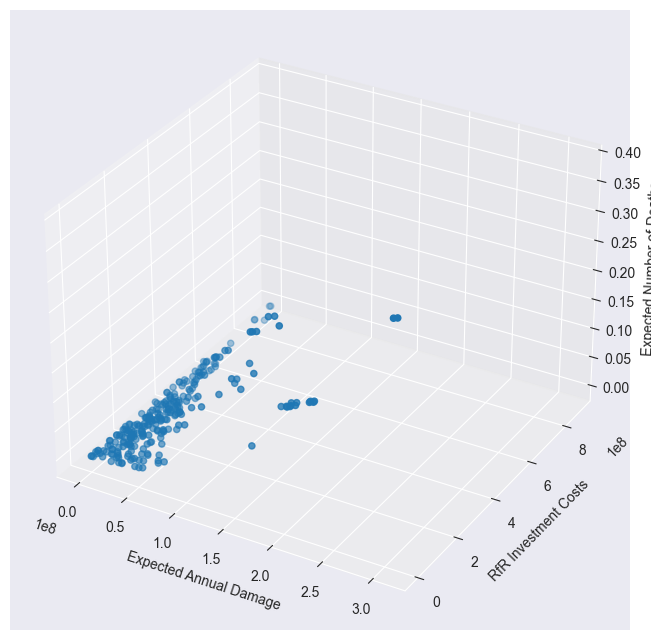

In [13]:
from mpl_toolkits.mplot3d import Axes3D  

outcomes = results_optimization.loc[:, ['Expected Annual Damage', 'RfR Investment Costs', 'Expected Number of Deaths']]

fig = plt.figure(figsize=(8,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outcomes['Expected Annual Damage'], outcomes['RfR Investment Costs'], outcomes['Expected Number of Deaths'])
ax.set_xlabel('Expected Annual Damage')
ax.set_ylabel('RfR Investment Costs')
ax.set_zlabel('Expected Number of Deaths')
plt.show()

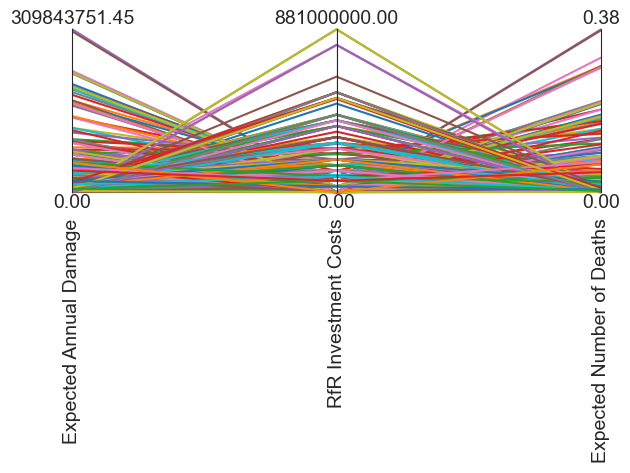

In [14]:
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
# axes.invert_axis('max_P') 
plt.show()

In [15]:
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress)

from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem

def calculate_metrics(archives, reference_set):
    problem = to_problem(dike_model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel(r"$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

In [16]:
archives = ArchiveLogger.load_archives(f"./archives/optimizer_sven.tar.gz")

reference_set = results_optimization
problem = to_problem(dike_model, searchover="levers")

hv = HypervolumeMetric(reference_set, problem)

hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel(r'$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive

In [18]:
archives = ArchiveLogger.load_archives(f"./archives/optimizer_sven.tar.gz")
reference_set = archives[max(archives.keys())] # this is the final archive
reference_set = reference_set.drop(columns=['Unnamed: 0'])
metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive

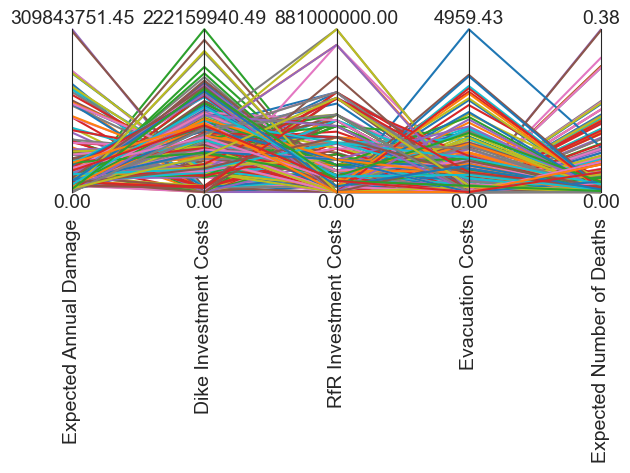

In [19]:
data = results_optimization.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'RfR Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
# paraxes.invert_axis('max_P')
plt.show()

In [43]:
results_optimization

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,2.057396e+08,0.000000e+00,30700000.0,0.000000,0.181555
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.744181e+08,0.000000e+00,84600000.0,0.000000,0.295206
2,0,0,0,0,0,0,0,0,0,0,...,0,0,7,3,0,0.000000e+00,2.221599e+08,0.0,0.000000,0.000000
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1.421926e+08,0.000000e+00,115300000.0,0.000000,0.193531
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.098438e+08,0.000000e+00,0.0,0.000000,0.381333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,1,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,1.464937e+07,1.159138e+08,84600000.0,526.742670,0.004740
260,0,0,0,0,0,0,0,0,1,0,...,0,0,4,0,0,2.127358e+07,1.376488e+08,30700000.0,814.623133,0.006095
261,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,5.602701e+07,9.415543e+07,0.0,0.000000,0.064686
262,0,0,0,0,0,0,0,1,1,0,...,0,0,3,0,0,6.027998e+06,1.410464e+08,61400000.0,192.531570,0.002571


In [87]:
import numpy as np

condition_deaths = results_optimization['Expected Number of Deaths'] < 0.0002
condition_damage = results_optimization['Expected Annual Damage'] <  1.227898e+05
condition_RfRcosts = results_optimization['RfR Investment Costs'] > 176700000.0
condition_dikecosts = results_optimization['Dike Investment Costs'] < 3.043865e+08

logical = condition_deaths  & condition_damage & condition_RfRcosts &condition_dikecosts 

np.sum(logical)

6

In [68]:
l = 8.827852e+07 + 881000000.0
l

969278520.0

In [89]:
policies = results_optimization[logical]
# policies = policies.drop([o.name for o in dike_model.outcomes], axis=1)
# policies['total costs'] = policies['RfR Investment Costs'] + policies['Dike Investment Costs']
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
20,1,0,0,0,0,0,1,1,1,1,...,0,2,1,0,0,0.000000,8.944301e+07,540300000.0,0.000000,0.000000
78,1,0,0,0,0,0,1,1,1,1,...,0,2,2,0,0,0.000000,9.198402e+07,419100000.0,0.000000,0.000000
106,1,0,0,0,0,0,0,0,1,1,...,0,0,4,0,0,0.000000,1.138713e+08,236500000.0,0.000000,0.000000
157,1,0,1,0,0,0,1,1,1,1,...,0,1,2,0,0,91373.656936,8.827852e+07,881000000.0,6.198099,0.000009
185,1,0,0,0,0,0,1,0,0,1,...,0,0,3,0,0,0.000000,1.088155e+08,357700000.0,0.000000,0.000000
196,0,0,1,0,0,0,1,0,1,1,...,0,0,2,0,0,0.000000,1.086575e+08,388400000.0,0.000000,0.000000


In [90]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [91]:
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_8policies = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 1000 scenarios * 6 policies * 1 model(s) = 6000 experiments
100%|██████████████████████████████████████| 6000/6000 [04:09<00:00, 24.02it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [92]:
save_results(results_8policies, 'data/runs/results_sven_policies.tar.gz')
# results2 = load_results('data/runs/open_exploration_1000sc_1pol.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\svenk\Documents\GitHub\EPA141A-Model-based-decision-making\final assignment\data\runs\results_sven_policies.tar.gz


In [109]:
outcomes['Expected Number of Deaths']

array([4.91466936e-02, 1.27195268e+00, 6.75733629e-03, ...,
       1.03026961e-03, 2.67140578e-03, 9.74173148e-02])

In [93]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [94]:
experiments, outcomes = results_8policies

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
106,3.003355e+17,3.393628,0.0,0.000000e+00,0.176614
157,9.130286e+16,0.000000,0.0,3.951358e+07,0.001573
185,3.129904e+17,1.621477,0.0,9.230941e+07,0.004598
196,2.826206e+17,4.857370,0.0,9.445209e+07,0.002181
20,2.863809e+17,1.332805,0.0,0.000000e+00,0.163488
78,3.020665e+17,1.370669,0.0,8.298749e+07,0.004218


In [98]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,119,41.172918,1.5,0.261706,147.253227,1.0,0.946389,304.567659,1.0,0.368598,...,0,3,0,2,1,0,0,1000,20,dikesnet
1,82,46.565828,1.5,0.015054,257.216589,1.0,0.238925,55.720023,1.0,0.841180,...,0,3,0,2,1,0,0,1001,20,dikesnet
2,83,38.144424,1.0,0.432869,243.937062,1.0,0.630017,331.615676,10.0,0.586234,...,0,3,0,2,1,0,0,1002,20,dikesnet
3,66,149.236257,10.0,0.843982,107.434345,10.0,0.400397,242.310127,10.0,0.496707,...,0,3,0,2,1,0,0,1003,20,dikesnet
4,2,286.741228,10.0,0.194898,185.773449,1.0,0.023117,285.275793,1.0,0.316449,...,0,3,0,2,1,0,0,1004,20,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,65,112.933991,1.0,0.426497,180.157424,1.0,0.837868,277.946196,1.5,0.810141,...,0,5,0,0,2,0,0,1995,196,dikesnet
5996,123,242.995318,1.5,0.105969,265.896076,1.5,0.233672,126.421841,1.0,0.389966,...,0,5,0,0,2,0,0,1996,196,dikesnet
5997,111,164.315870,1.5,0.388981,40.862808,1.0,0.549945,143.465440,1.5,0.527990,...,0,5,0,0,2,0,0,1997,196,dikesnet
5998,0,42.110318,10.0,0.346229,226.760367,1.0,0.423633,101.995765,1.0,0.469147,...,0,5,0,0,2,0,0,1998,196,dikesnet


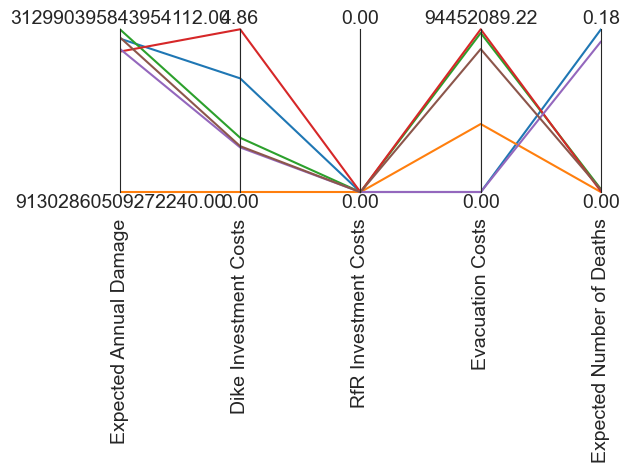

In [95]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
# limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
# paraxes.invert_axis('max_P')
plt.show()

In [99]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [100]:
experiments, outcomes = results_8policies

overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

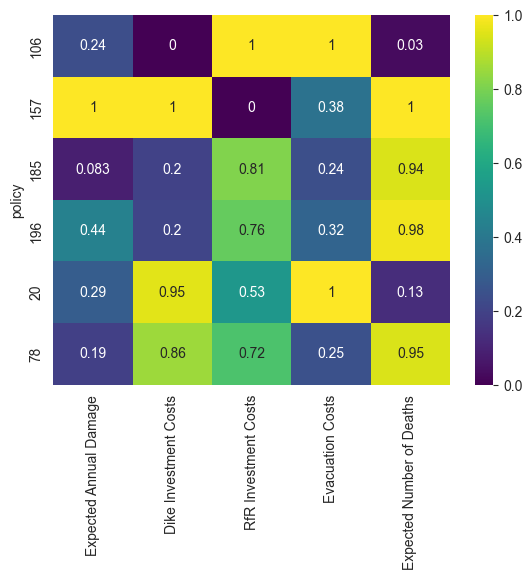

In [101]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

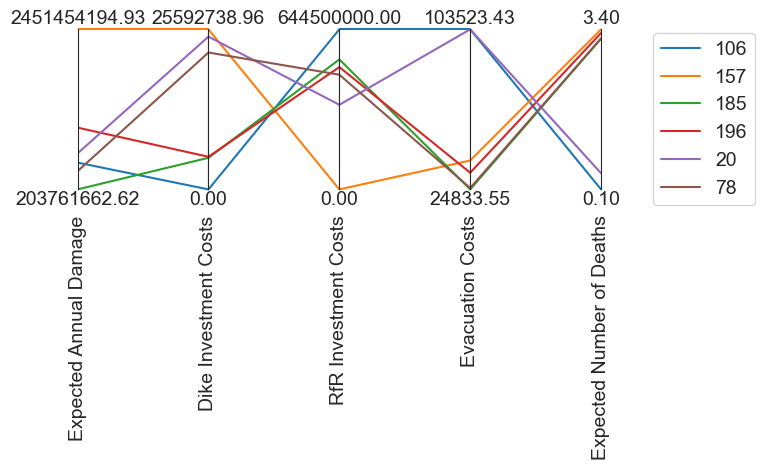

In [102]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
# limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

In [103]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\5699562.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\svenk\AppData\Local\Temp\ipykernel_19524\5699562.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


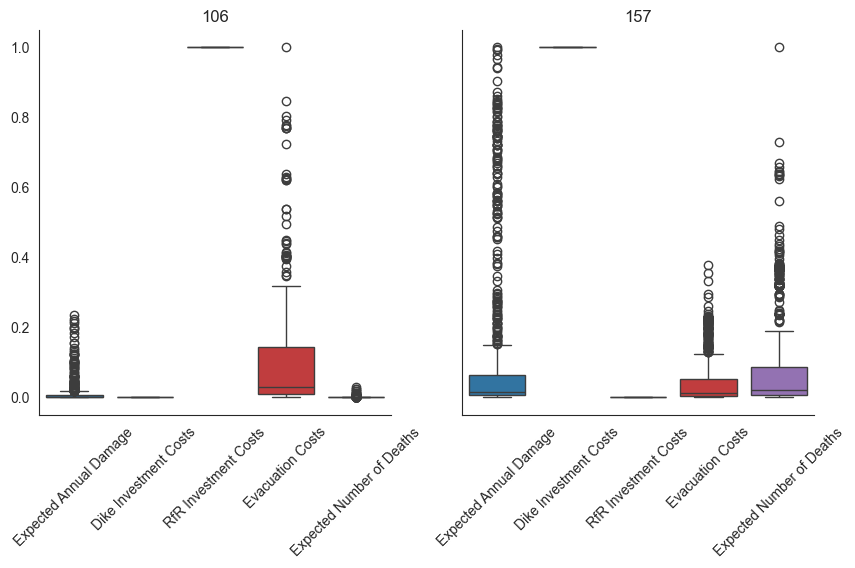

In [104]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 


# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [105]:
from ema_workbench.analysis import prim

x = experiments.drop(columns=['0_RfR 0',
                          '0_RfR 1',
                          '0_RfR 2',
                          '1_RfR 0',
                          '1_RfR 1',
                          '1_RfR 2',
                          '2_RfR 0',
                          '2_RfR 1',
                          '2_RfR 2',
                          '3_RfR 0',
                          '3_RfR 1',
                          '3_RfR 2',
                          '4_RfR 0',
                          '4_RfR 1',
                          '4_RfR 2',
                          'EWS_DaysToThreat',
                          'A.1_DikeIncrease 0',
                          'A.1_DikeIncrease 1',
                          'A.1_DikeIncrease 2',
                          'A.2_DikeIncrease 0',
                          'A.2_DikeIncrease 1',
                          'A.2_DikeIncrease 2',
                          'A.3_DikeIncrease 0',
                          'A.3_DikeIncrease 1',
                          'A.3_DikeIncrease 2',
                          'A.4_DikeIncrease 0',
                          'A.4_DikeIncrease 1',
                          'A.4_DikeIncrease 2',
                          'A.5_DikeIncrease 0',
                          'A.5_DikeIncrease 1',
                          'A.5_DikeIncrease 2',
                          'policy'
                          ])
# y = outcomes['RfR Investment Costs'] < 0.5

y = outcomes['Expected Number of Deaths'] < np.percentile(outcomes['Expected Number of Deaths'], 20)
prim_alg = prim.Prim(x, y, threshold=0.7)
box = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 6000 points remaining, containing 1200 cases of interest
[MainProcess/INFO] mean: 0.9738562091503268, mass: 0.051, coverage: 0.24833333333333332, density: 0.9738562091503268 restricted_dimensions: 5


In [106]:
box.inspect_tradeoff()

alt.VConcatChart(...)

In [107]:
outcomes['RfR Investment Costs']

array([5.403e+08, 5.403e+08, 5.403e+08, ..., 3.884e+08, 3.884e+08,
       3.884e+08])